In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy.matlib
import scipy.io
import warnings
from numpy.random import randint
from numpy.random import rand
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from numpy import asarray
warnings.filterwarnings('ignore')


In [2]:
def load_data(url):    
    df2 = pd.read_csv(url)
    data = df2.drop('target', axis=1)
    target= df2['target'].tolist()
    shape=(64,64)
    return data, target,shape
def pcatrain(data,threshhoold):
    pca_raw = PCA().fit(data)   
    pca = PCA(n_components=len(np.where(pca_raw.explained_variance_ratio_.cumsum() > threshhoold))).fit(data)
    return pca, pca_raw.explained_variance_ratio_.cumsum()


In [15]:
%%time
# genetic algorithm search for continuous function optimization

def selection(pop, scores):
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), 2):
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, crossover_rate):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < crossover_rate:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]


def mutation(binary, mutation_rate):
    for i in range(len(binary)):
        # check for mutation
        if rand() < mutation_rate:
            binary[i] = 1 - binary[i]
def fittness(x,y,z):
    dist = z+np.linalg.norm(y.flatten()-x.flatten()-np.dot(np.dot(np.transpose(x.flatten()),(x.flatten())),y.flatten()-x.flatten()))**2
    return dist
# objective function
def objective(data,x,punishment):
    test=data.values[-1]
    data=data.values[:-1]
    testsample=np.dot(x,data)
    z=np.count_nonzero(x)*punishment
    return fittness(test,testsample,z)

# binary_scaling binary to numbers
def binary_scaling(boundary, round_lv, binary):
    scaled = []
    maxv= 2**round_lv
    for i in range(len(boundary)):
        substring = binary[(i*round_lv) : ((i*round_lv)+round_lv)]
        # convert binary to an integer
        integer = int(''.join([str(s) for s in substring]), 2)
        # scale integer
        value = boundary[i][0] + (integer/maxv) * (boundary[i][1] - boundary[i][0])
        scaled.append(value)
    return scaled

# GA
def genetic_algorithm(boundary, round_lv, iteration, population_size, crossover_rate, mutation_rate,punishment):
    # initial values
    score_list=[]
    pop = [randint(1, 2, round_lv*len(boundary)).tolist() for i in range(population_size)]
    local_min_list	=0
    distance_value 	= objective(data,binary_scaling(boundary, round_lv, pop[0]),punishment)
    #bar = IncrementalBar('Countdown', max = iteration)
    #star interations
    for generation in range(iteration):
        #bar.next()
        #time.sleep(1)           
        #print("iteration:  ", generation)
        # binary_scaling population
        scaled = [binary_scaling(boundary, round_lv, p) for p in pop]
        # evaluate scores
        scores = [objective(data,d,punishment) for d in scaled]
        # check for new local_min_list solution
        for i in range(population_size):
            if scores[i] < distance_value:
                local_min_list, distance_value = pop[i], scores[i]
        score_list.append(distance_value)                

        # matching parents
        selected = [selection(pop, scores) for _ in range(population_size)]
        # parent get married and give birth to mutaned children,
        children = []
        for i in range(0, population_size, 2):
            # 
            p1, p2 = selected[i], selected[i+1]
            for c in crossover(p1, p2, crossover_rate):
                mutation(c, mutation_rate)
                children.append(c)
        # replace parents with children
        pop = children
    #bar.finish()
    return local_min_list, distance_value,score_list




Wall time: 0 ns


In [55]:
#parameters
testimg=52
boundary = [[0, 1.0]]*(data.shape[0]-1)
iteration = 200
round_lv = 2
population_size = 100
crossover_rate = 0.9
punishment =1000
mutation_rate = 1.0 / (float(round_lv) * len(boundary))
# run genetic algorithm 

In [50]:
#Data loading
data2, target,shape= load_data('data/face_data/face_data.csv')

data=data2[:1]
data=data.reset_index(drop=True)
for i in range(0,40):
    pca = PCA().fit(data2[10*i:(10*i+10)])
    if (i==0):
        data.loc[0]=pca.mean_.tolist()
    else:
        data.loc[len(data.index)]=pca.mean_.tolist()
test=data2.values[testimg]
data.loc[len(data.index)]=test.tolist()

Genetic Algorithm finished!
Created by: [0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fiteness level: 69012160.53112271
Wall time: 52.6 s


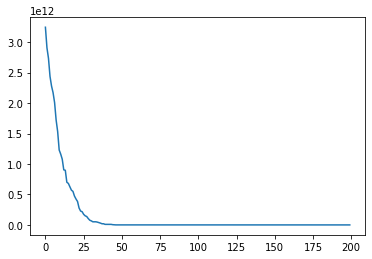

In [56]:
%%time
#GA construction array
local_min_list, score,score_list = genetic_algorithm(boundary, round_lv, iteration, population_size, crossover_rate, mutation_rate,punishment)
print('Genetic Algorithm finished!')
scaled = binary_scaling(boundary, round_lv, local_min_list)
print('Created by: %s' % scaled)
print('fiteness level: %s' % score)
plt.plot(score_list)



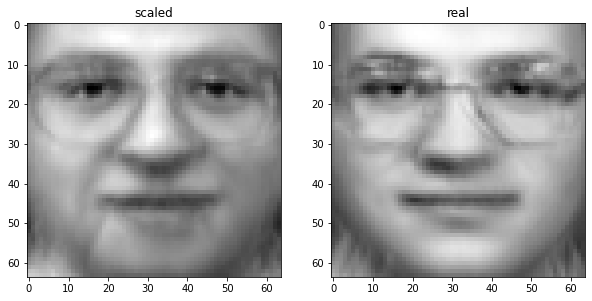

Wall time: 618 ms


In [57]:
%%time
#check the resule img
testdata=data.values[:-1].astype(float)
x=[0]*40
x[int(testimg/10)]=1

ls=np.array([np.dot(scaled,testdata).reshape(shape),np.dot(x,testdata).reshape(shape)])
name=['scaled','real']
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(ls[i].reshape(shape), cmap='gray')
    ax.set_title(name[i])
plt.show()